In [62]:
import numpy as np
import pylab as plt

import chainer
import chainer.functions as F
import chainer.links as L

from chainer import datasets
from PIL import Image
import matplotlib.pyplot as PLT
import json
import pandas as pd
import os
from lxml import etree


from chainer import datasets

In [63]:
#get images file list
file_list = []
for root, dirs, files in os.walk('./images/'):
    for file in files:
            file_list.append(file)

In [56]:
#get cut_images_size into a file list
Csize_file_list = []
for root, dirs, files in os.walk('./annotations/xmls/'):
    for file in files:
        if 'check' in os.path.splitext(file)[0]:
            print('check_img found')
        else:
            Csize_file_list.append(file)
 
C_all_data=[]
C_index = []
for i in Csize_file_list:
    C_one_data = []
    xml = etree.parse('./annotations/xmls/%s'%(i))
    xmin = xml.xpath('//bndbox/xmin/text()')
    ymin = xml.xpath('//bndbox/ymin/text()')
    xmax = xml.xpath('//bndbox/xmax/text()')
    ymax = xml.xpath('//bndbox/ymax/text()')
    index = xml.xpath('//filename/text()')
    C_one_data.append(int(str(xmin[0])))
    C_one_data.append(int(str(ymin[0])))
    C_one_data.append(int(str(xmax[0])))
    C_one_data.append(int(str(xmax[0])))
    C_all_data.append(C_one_data)
    C_index.append(str(index[0]))
C_df = pd.DataFrame(C_all_data,columns=['xmin','ymin','xmax','ymax'],index = C_index)

In [71]:
def load_image(img_path,augmentation=False, size=(224, 224)):
    i = img_path 
    img = Image.open('./images/%s'%i)
    img = img.resize((size),Image.ANTIALIAS)
    # 短辺長を基準とした正方形の座標を得る
    x_center = img.size[0] // 2
    y_center = img.size[1] // 2
    half_short_side = min(x_center, y_center)
    x0 = x_center - half_short_side
    y0 = y_center - half_short_side
    x1 = x_center + half_short_side
    y1 = y_center + half_short_side
    # Augmentation
    if augmentation:
                    # rotation
            if np.random.random() > 0.5:
                        angle = np.random.uniform(-10, 10)
                        img = img.rotate(angle, resample=Image.BILINEAR)
                    # flip
            if np.random.random() > 0.5:
                        img = img.transpose(Image.FLIP_LEFT_RIGHT)
                    # shift and scaling
            if np.random.random() > 0.5:
                        range_x = img.size[0] // 10
                        range_y = img.size[1] // 10
                        x0 = max(0, np.random.randint(x0 - range_x, x0 + range_x))
                        y0 = max(0, np.random.randint(y0 - range_y, y0 + range_y))
                        x1 = min(img.size[0], np.random.randint(x1 - range_x, x1 + range_x))
                        y1 = min(img.size[1], np.random.randint(y1 - range_y, y1 + range_y))
    img = img.crop((x0, y0, x1, y1))
    img = img.resize((size),Image.ANTIALIAS)
    img = np.array(img, dtype=np.float32)
                
    if img.shape[2] != 3:
        img = img[:2]
    if img.shape[1] != 224:
        img = img[:224]
    if img.shape[0] != 224:
        img = img[:224]
    img = img.transpose(2,1,0)
    return img
x = load_image('Abyssinian_6.jpg', 0)
print(x.shape)

(3, 224, 224)


In [72]:
# データの分割
all_list = []
label_list = []
test_data = []
train_data =[]

#locate train images and label on json
train_label = []
train_data_name = []
train_list_slice_c = []
train_list_slice_d = []

data_str = open('./train.json').read()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth',100)
df = pd.read_json(data_str)
for j in range(12):
    train_list_slice_c= train_list_slice_c+(df.iloc[:12,0].iloc[j]['images'])
    for count_c in df.iloc[:12,0].iloc[j]['images']:
        train_data.append((count_c+'.jpg',1))
      
for i in range(23):
    train_list_slice_d= train_list_slice_d+(df.iloc[12:,1].iloc[i]['images'])
    for count_d in df.iloc[12:,1].iloc[i]['images']:
        train_data.append((count_d+'.jpg',2))

train_data_name =train_list_slice_c+train_list_slice_d


#locate test images and label on json
test_label =[]
test_data_name = []
test_list_slice_c = []
test_list_slice_d = []

data_str = open('./test.json').read()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth',100)
df = pd.read_json(data_str)
test_label = []
test_list_slice = []
for j in range(12):
    test_list_slice_c= test_list_slice_c+(df.iloc[:12,0].iloc[j]['images'])
    for count_c in df.iloc[:12,0].iloc[j]['images']:
        test_data.append((count_c+'.jpg',1))
for i in range(23):
    test_list_slice_d= test_list_slice_d+(df.iloc[12:,1].iloc[i]['images'])
    for count_d in df.iloc[12:,1].iloc[i]['images']:
        test_data.append((count_d+'.jpg',2))
    
test_data_name = test_list_slice_c+test_list_slice_d
    
    
all_list = test_data_name+train_data_name 

all_list = [jpg+'.jpg' for jpg in all_list]

print(train_data[1][0])
print(len(test_data))
print(len(train_data_name))

    

Abyssinian_51.jpg
5382
1967


In [73]:
##turn into tumple dataset
t_train=[]
l_train = []
for i in range(len(train_data)):
    x_train = load_image(train_data[i-1][0],augmentation = True)
    if x_train.shape[0] == 3:
        l_train.append(x_train)
        t_train.append(train_data[i-1][1])
t_test =[]
l_test = []
for i in range(len(test_data)):
    x_test = load_image(test_data[i-1][0],augmentation = True)
    l_test.append(x_test)
    t_test.append(test_data[i-1][1])


In [74]:
##Tuple dataset function
import six
class TupleDataset(object):
    def __init__(self, *datasets):
        if not datasets:
            raise ValueError('no datasets are given')
        length = len(datasets[0])
        for i, dataset in enumerate(datasets):
            if len(dataset) != length:
                raise ValueError(
                    'dataset of the index {} has a wrong length'.format(i))
        self._datasets = datasets
        self._length = length

    def __getitem__(self, index):
        batches = [dataset[index] for dataset in self._datasets]
        if isinstance(index, slice):
            length = len(batches[0])
            return [tuple([batch[i] for batch in batches])
                    for i in six.moves.range(length)]
        else:
            return tuple(batches)

    def __len__(self):
        return self._length

tuple_dataset_train = TupleDataset(l_train,np.array(t_train))
print(tuple_dataset_train[1950][0].shape)
tuple_dataset_test = TupleDataset(l_test,np.array(t_test))
print(type(tuple_dataset_test[2000][1]))

(3, 224, 224)
<class 'numpy.int64'>


In [75]:
class PetTripletDataset(chainer.dataset.DatasetMixin):

    def __init__(self):
        train = tuple_dataset_train
        test = tuple_dataset_test

        self.X = []
        self.T = []
        self.t2inds = {}
        self.labels = np.arange(1,3, dtype=np.int32)

        ind = 0
        for x, t in tuple_dataset_train:
            if t not in self.t2inds:
                self.t2inds[t] = []            
            x = x.transpose(2,1,0)                  
#            x = x[::-1]            
#            x -= np.array([103.939, 116.779, 123.68],dtype=np.float32).reshape(3, 224, 224)
            
            self.X.append(x)
            self.T.append(t)
            self.t2inds[t].append(ind)
            ind += 1

    def __len__(self):
        return len(self.T)

    def get_example(self, i):
        x = self.X[i].reshape(3,224,224)
        t = self.T[i]

        # positive sample
        ind_p = np.random.choice(self.t2inds[t])
        x_p = self.X[ind_p].reshape(3,224,224)

        # negative sample
        label = np.random.choice(self.labels[self.labels!=t])
        ind_n = np.random.choice(self.t2inds[label])
        x_n = self.X[ind_n].reshape(3,224,224)

        return x, t, x_p, x_n

In [76]:
dataset = PetTripletDataset()

In [77]:
for i in range(1960):
    x, t, x_p, x_n = dataset[i]
    if x.shape[0] != 3:
        print(x.shape)
        print(i)

(3, 224, 224)


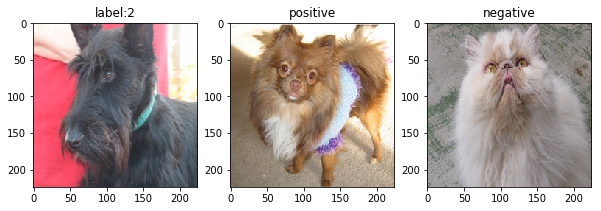

In [78]:
x, t, x_p, x_n = dataset[1963]

print(x.shape)
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.title('label:{}'.format(t))
plt.imshow(x.reshape(224,224,3)/255, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('positive')
plt.imshow(x_p.reshape(224,224,3)/255, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('negative')
plt.imshow(x_n.reshape(224,224,3)/255, cmap='gray')

In [79]:
#building chainer & intial VGG16 model
import numpy as np
import chainer
from chainer import datasets, iterators, optimizers, serializers
from chainer import Function
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L

from chainer import backend
from chainer import backends
from chainer.backends import cuda
from chainer.training import extensions
import cupy


In [95]:
#import VGG16
class Model(chainer.Chain):
    def __init__(self):
        super(Model, self).__init__()
        with self.init_scope():
            self.vgg = L.VGG16Layers()
            self.fc = L.Linear(None, 17)

    def __call__(self, x, train=False):
        with chainer.using_config('train', train):
            h = self.vgg(x, layers=['fc7'])['fc7']
            y = self.fc(h)
        return y
model = Model()
model = model.to_gpu()

In [96]:
#count loss
class TripletLoss(chainer.Chain):
    def __init__(self, model):
        super(TripletLoss, self).__init__()
        with self.init_scope():   
            self.model = model

    def __call__(self, x, t, x_p, x_n):
        x = model.xp.array(x)
        x_p = model.xp.array(x_p)
        x_n = model.xp.array(x_n)
        
        y = self.model(x)
        y_p = self.model(x_p)
        y_n = self.model(x_n)
        loss = F.triplet(y, y_p, y_n)
        
        y_0 = y[t==0]
        if len(y_0) > 0:
            loss += 0.1 * F.mean((y_0 ** 2))

        chainer.report({'loss': loss}, self)
        return loss
loss = TripletLoss(model)

In [97]:
from chainer import iterators
from chainer import training
from chainer.training import extensions
import numpy as np
import chainer
from chainer import backend
from chainer import backends
from chainer.backends import cuda
from chainer.training import extensions


In [98]:
n_epoch = 6
batchsize = 16
out_dir = './result/'
report_interval = (10, 'iteration')
train_iter = iterators.MultithreadIterator(dataset, batchsize, repeat=True, shuffle=True)

In [99]:
# optimizer = chainer.optimizers.Adam(alpha=1e-3, amsgrad=True)
optimizer = chainer.optimizers.MomentumSGD(lr=1e-6)
optimizer.setup(loss)
updater = training.StandardUpdater(train_iter, optimizer, device=0)

In [100]:
trainer = training.Trainer(updater, (n_epoch, 'epoch'), out=out_dir)

trainer.extend(extensions.LogReport(trigger=report_interval))
trainer.extend(extensions.PrintReport(['epoch', 'iteration', 'main/loss']),
               trigger=report_interval)
trainer.extend(extensions.PlotReport(y_keys='main/loss', trigger=report_interval))

In [101]:
trainer.run()

epoch       iteration   main/loss 
0           10          1.56073     
0           20          1.34039     
0           30          0.793957    
0           40          0.790466    
0           50          0.639395    
0           60          0.554736    
0           70          0.578266    
0           80          0.553646    
0           90          0.478368    
0           100         0.527306    
0           110         0.438747    
0           120         0.482898    
1           130         0.541525    
1           140         0.456281    
1           150         0.348797    
1           160         0.497982    
1           170         0.431881    
1           180         0.380367    
1           190         0.297589    
1           200         0.366199    
1           210         0.220576    
1           220         0.301173    
1           230         0.323554    
1           240         0.324924    
2           250         0.303019    
2           260         0.262415    
2  

In [102]:
chainer.serializers.save_npz('./Vgg_pet3.model', model)

In [8]:
chainer.serializers.load_npz('./Vgg_pet2.model', model)

Evaluate

In [103]:
import cupy as cp 
X = []
T = []
for x, t in tuple_dataset_test:
#    x = x.transpose(2,1,0)
    #if t != 0 and np.random.random() > 0.01:
    #    continue
    X.append(x)
    T.append(t)
X = np.array(X,dtype=np.float32)
T = np.array(T,dtype=np.int32)
X = model.xp.array(X)

In [104]:
X.shape

(5382, 3, 224, 224)

In [105]:
L=[]
for i in range(5382):
    Y = model(X[i][np.newaxis]).data
    L.append(Y)

In [106]:
Y = np.array(L)

In [107]:
Y.shape

(5382, 1, 17)

In [129]:
print(Y[])

[-1.3637376   1.8901672  -2.8329291  -0.23565191 -1.8336453  -1.0611893
 -3.1353192   0.6820544   0.84829235 -1.6713243  -0.37703484 -1.2526687
  0.47062942 -0.93572706 -1.1891568  -1.4268063  -0.6719572 ]


In [108]:
Y = chainer.cuda.to_cpu(L)
Y = np.array(Y)
Y = Y.reshape((5382,17))

In [109]:
from sklearn.manifold import TSNE

In [110]:
Y_embedded = TSNE(n_components=2).fit_transform(Y)

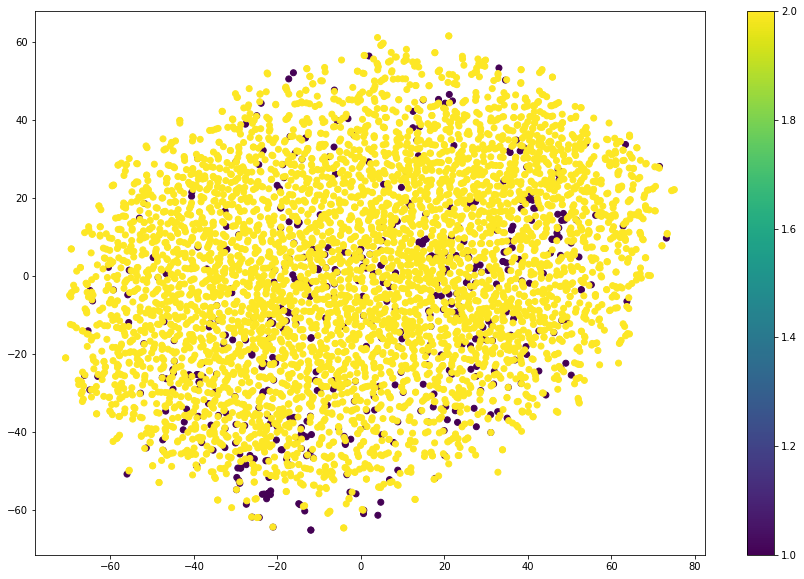

In [112]:
plt.figure(figsize=(15, 10))
plt.scatter(Y_embedded[:, 0], Y_embedded[:,1], c=T)
plt.colorbar()

In [113]:
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score

In [114]:
distance_from_origin = np.sqrt(np.sum(Y ** 2, axis=1))

In [127]:
print(distance_from_origin)

[6.206454  4.3152485 4.800551  ... 6.0833917 2.9427905 3.584137 ]


In [130]:
score = distance_from_origin / distance_from_origin.max()
print(score)

[0.58019924 0.40340328 0.4487709  ... 0.56869495 0.2751015  0.33505663]


In [132]:
T = (T != 0)

In [134]:
precision, recall, _ = precision_recall_curve(T, score)

average_precision = average_precision_score(T, score)
print(precision)
print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

[1. 1. 1. ... 1. 1. 1.]
Average precision-recall score: 1.00


Text(0.5,1,'2-class Precision-Recall curve: AP=1.00')

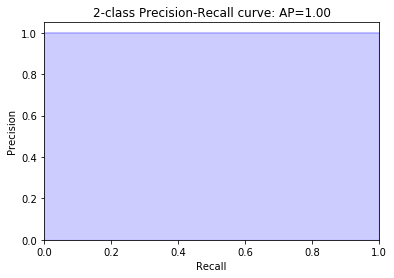

In [118]:
# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [119]:
# chance rate(全部 positive と判定した場合の precision)
len(T[T!=0]) / len(T)

1.0

In [120]:
(T==0).sum()

0

In [123]:
for i in precision:
    if i !=1:
        print(precision[i].index)


In [122]:
for i in recall:
    if i > 0.999:
        print(i)

1.0
0.9998141954663694
0.9996283909327388
0.9994425863991081
0.9992567818654775
0.9990709773318469
